# Content Based Recommendations and Tag Clustering
## 08/01/2020

The purpose of this notebook is to explore the content based recommendations we can perform based off author and genre of a given book. We do not explicitly have the genres of books, what we do have is a long list of tags for each book (i.e. happy, dark fantasy, morning reads, 1920s, etc.).

These tags are a compiled list of custom tags given to books by users on Goodreads.com, therefore many are super personal and not too meaningful in terms of determining genre. We have done some extensive cleaning of the tags in a notebook called **```tags_cleaning.ipynb```** and replicate some of that cleaning here.


In [54]:
#Library Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import string
import warnings
import datetime


#Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


#Tags Clusters
from sklearn.cluster import KMeans

#Stats
from scipy import stats

warnings.filterwarnings('ignore')

In [2]:
#Data Imports

#Book Info
books = pd.read_csv("../data/raw_data/books.csv")
print(books.shape)
print(books.columns)

#User ratings
print()
ratings = pd.read_csv("../data/raw_data/ratings.csv")
print(ratings.shape)
print(ratings.columns)

#User Book viewing history
print()
toRead = pd.read_csv("../data/raw_data/to_read.csv")
print(toRead.shape)
print(toRead.columns)

#Tag ID mapped to the actual tag 
print()
tags = pd.read_csv( '../data/raw_data/tags.csv' )
print(tags.shape)
print(tags.columns)

#Mappings of books and tags that are associated to book

print()
book_tags = pd.read_csv( '../data/raw_data/book_tags.csv')
print(book_tags.shape)
print(book_tags.columns)

(10000, 23)
Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url'],
      dtype='object')

(5976479, 3)
Index(['user_id', 'book_id', 'rating'], dtype='object')

(912705, 2)
Index(['user_id', 'book_id'], dtype='object')

(34252, 2)
Index(['tag_id', 'tag_name'], dtype='object')

(999912, 3)
Index(['goodreads_book_id', 'tag_id', 'count'], dtype='object')


### Books Cleaning

We drop columns that won't be needed now.

In [3]:
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [4]:
#From Books table we drop some of the columns we don't see direct use for
drop_cols =['best_book_id', 'work_id','isbn', 'isbn13']
books.drop(drop_cols, axis=1, inplace=True)
print(books.columns)

Index(['book_id', 'goodreads_book_id', 'books_count', 'authors',
       'original_publication_year', 'original_title', 'title', 'language_code',
       'average_rating', 'ratings_count', 'work_ratings_count',
       'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3',
       'ratings_4', 'ratings_5', 'image_url', 'small_image_url'],
      dtype='object')


**Look for what types of languagse are covered in our data.**

In [5]:
#Drop all NaN rows
books.dropna(subset=['language_code'])

#Check what type of languages are covered in the books
lang_codes = np.array(list(books["language_code"]))
u_langs = np.unique(lang_codes)

print(len(lang_codes))
print(len(u_langs))
u_langs

10000
26


array(['ara', 'dan', 'en', 'en-CA', 'en-GB', 'en-US', 'eng', 'fil', 'fre',
       'ger', 'ind', 'ita', 'jpn', 'mul', 'nan', 'nl', 'nor', 'per',
       'pol', 'por', 'rum', 'rus', 'spa', 'swe', 'tur', 'vie'],
      dtype='<U5')

**We've decided that we want our recommendation system to only learn and be focussed on English content. For now being able to build a recommender that can take account of language and the implications that come with the understanding of multiple foreign languages of the same time is out of scope for now**

In [6]:
#Only English content
lang_mask = [False if math.isnan(b) else b for b in books['language_code'].str.contains("en")]    
np.unique(lang_mask)

array([False,  True])

In [7]:
#Apply boolean mask 

books = books[lang_mask]

In [8]:
#We see our rows drop from 10,000 to 8,730
books.shape

(8730, 19)

In [9]:
# Books data without some columns, and taking out non-english content
# books.to_csv(r'/Users/karthikrameshbabu/midsScratch/MIDS/w207/BooksFinalProject/MIDS207-Final-Project/data/parsed_data/english_books_cf.csv', index = False)



### Tags Cleaning


Steps taken from the Tags Cleaning Notebook

In [10]:
t_copy = tags.copy()
t_copy['tag_name'] = t_copy['tag_name'].apply(lambda x: x.lower())
t_copy = t_copy[19:]
t_copy = t_copy[(True == t_copy['tag_name'].str.match(r"^[a-zA-Z0-9$@$!%*?&#':;^\-—_,'\\/\". +()]+$"))]
t_copy.head()

,tag_id,tag_name
19,19,--available-at-raspberrys--
20,20,-2001--
21,21,-calif--
22,22,-d-c--
23,23,-dean


In [11]:
# Join tag IDs with te tag names
t_joined = pd.merge(book_tags, t_copy, left_on='tag_id', right_on='tag_id', how='inner')
t_joined.head()

,goodreads_book_id,tag_id,count,tag_name
0,1,30574,167697,to-read
1,2,30574,24549,to-read
2,3,30574,496107,to-read
3,5,30574,11909,to-read
4,6,30574,298,to-read


In [12]:
#Get rid of punctuations from the tags
t_joined["tag_name"] = [tag.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))) for tag in t_joined["tag_name"]]
print(t_joined.shape)
t_joined.head()

(994023, 4)


,goodreads_book_id,tag_id,count,tag_name
0,1,30574,167697,to read
1,2,30574,24549,to read
2,3,30574,496107,to read
3,5,30574,11909,to read
4,6,30574,298,to read


In [13]:
#Somewhat rudementary but this works! To get rid of a solid chunk of user custom tags.
user_tags1 = 'to read+|reading+|my books+|wish list+|novel+|series+|^[[:digit:]]*$|i own+|currently+|own+|have+|[^[:alnum:] ]|favorite+|favourite+|'
user_tags2 = 'club+|buy+|library+|read+|borrowed+|abandoned+|audio+|ya|e book+|ebook+|kindle+|default+|finish+|maybe+|gave up+|'
user_tags3 = 'dnf+|stars+|^(15|16|17|18|19|20)\d{2}[a-zA-Z]*|century+|grade+'

user_tags = user_tags1+user_tags2 + user_tags3
del_filter = t_joined["tag_name"].str.contains(user_tags)

#Update value of our tags
t_joined = t_joined[~del_filter]

print(t_joined.shape)
t_joined.head()

(542862, 4)


,goodreads_book_id,tag_id,count,tag_name
9983,1,11305,37174,fantasy
9984,2,11305,3441,fantasy
9985,3,11305,47478,fantasy
9986,5,11305,39330,fantasy
9987,6,11305,38378,fantasy


### Concepts Referenced

#### Dot Products:
Algebraically, the dot product is the sum of the products of the corresponding entries of the two sequences of numbers. Geometrically, it is the product of the Euclidean magnitudes of the two vectors and the cosine of the angle between them.


In this case, the dot product is used for defining lengths (the length of a vector is the square root of the dot product of the vector by itself) and **angles** (the cosine of the angle of two vectors is the quotient of their dot product by the product of their lengths).



#### Kernel Trick:
The Kernel trick is a very interesting and powerful tool. It is powerful because it provides a bridge from linearity to non-linearity to any algorithm that can expressed solely on terms of dot products between two vectors. It comes from the fact that, if we first map our input data into a higher-dimensional space, a linear algorithm operating in this space will behave non-linearly in the original input space.



####  Cosine Similarity:
https://www.machinelearningplus.com/nlp/cosine-similarity/

Cosine similarity measures the degree to which two vectors point in the same direction, regardless of magnitude.

When vectors point in the same direction, cosine similarity is 1; when vectors are perpendicular, cosine similarity is 0; and when vectors point in opposite directions, cosine similarity is -1. In positive space, cosine similarity is the complement to cosine distance: cosine_similarity = 1 - cosine_distance.

For example, the cosine similarity between [1, 2, 3] and [3, 2, 1] is 0.7143.


### Similarity By Authors

In [14]:
books.shape

(8730, 19)

In [15]:
# Setup Author Name vectors, since most authors from our EDA just have firstname and/or last name, 
# we set a ngram_range to be 1 or 2 

tf_author = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tf_matrix_authors = tf_author.fit_transform(books['authors'])

print(tf_matrix_authors.shape)
cosine_sim_authors = cosine_similarity(tf_matrix_authors, tf_matrix_authors)
print(cosine_sim_authors.shape)

(8730, 13185)
(8730, 8730)


In [16]:
books.head()

,book_id,goodreads_book_id,books_count,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,226,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,487,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,1356,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [17]:
# All the books 
titles = books['title']
indices = pd.Series(books.index, index=books['title'])

# Book Recs based on the cosine similarity score of authors
def similarity_by_authors(book, num_recs=10):
    try:
        
        #Find the index of the book
        index = indices[book]
        
        #Using that index get the list of cosine similarities (list of 8730)
        # Each entry looks like >> (1135, 1.0)
        #                          (index in dataframe, similarity score)
        scores = list(enumerate(cosine_sim_authors[index]))
 
        #Order that list by cosine similaritie and get the indexes of the rows that are similar
        scores = sorted(scores, key=lambda x: x[1], reverse=True)

        # If you are asking for more recs than we even have books for that author
        # then give you all the books for that author
        if num_recs > len(scores):
            scores = scores[1:len(scores)]  
        else:
            #Give you number of recs you want
            scores = scores[1:num_recs]            

        print(scores)
        print()

        #Iterate and get all the indexes that we want to recommend
        book_indices = [book[0] for book in scores]

        
        #Pull list of books using those indexes!
        return books.iloc[book_indices]
    
    except:
        print("We don't have that book!")

In [18]:
similarity_by_authors('The Great Gatsby')

[(1135, 1.0), (2167, 1.0), (3358, 1.0), (6605, 0.5831356951529844), (7662, 0.43851346650878076), (1225, 0.2605102485970193), (7808, 0.224485040535046), (6135, 0.22089287902236984), (893, 0.22065958215380083)]



,book_id,goodreads_book_id,books_count,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
1183,1184,46164,406,F. Scott Fitzgerald,1933.0,Tender Is the Night,Tender Is the Night,en-US,3.83,79008,86768,3615,1719,5896,22117,32814,24222,https://images.gr-assets.com/books/1438797669m...,https://images.gr-assets.com/books/1438797669s...
2303,2304,46165,607,F. Scott Fitzgerald,1920.0,This Side of Paradise,This Side of Paradise,eng,3.68,40074,47633,2777,1137,4298,14047,17247,10904,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
3640,3641,747746,31,F. Scott Fitzgerald,1922.0,The Curious Case of Benjamin Button,The Curious Case of Benjamin Button,en-GB,3.53,30313,34715,2887,591,3578,13074,11805,5667,https://images.gr-assets.com/books/1331235364m...,https://images.gr-assets.com/books/1331235364s...
7408,7409,4662,62,"F. Scott Fitzgerald, Matthew J. Bruccoli",1920.0,The Short Stories of F. Scott Fitzgerald,The Short Stories,eng,4.23,11525,12955,282,95,307,1895,4846,5812,https://images.gr-assets.com/books/1400891315m...,https://images.gr-assets.com/books/1400891315s...
8683,8684,17557143,13,J.S. Scott,2013.0,The Billionaire's Obsession ~ Simon,The Billionaire's Obsession ~ Simon (The Billi...,eng,4.00,7492,16989,856,452,935,3307,5796,6499,https://images.gr-assets.com/books/1362454880m...,https://images.gr-assets.com/books/1362454880s...
1279,1280,12914,830,"Virgil, Robert Fitzgerald",-17.0,Æneis,The Aeneid,eng,3.81,75051,85351,1804,1531,6436,23683,28909,24792,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
8869,8870,119247,29,"John D. Fitzgerald, Mercer Mayer",1967.0,The Great Brain,The Great Brain (Great Brain #1),eng,4.16,13422,13870,776,242,389,2297,4876,6066,https://images.gr-assets.com/books/1311781413m...,https://images.gr-assets.com/books/1311781413s...
6862,6863,218659,37,"Flannery O'Connor, Robert Fitzgerald",1965.0,Everything that Rises Must Converge,Everything That Rises Must Converge: Stories,eng,4.27,14534,15025,873,163,433,1876,5312,7241,https://images.gr-assets.com/books/1412859621m...,https://images.gr-assets.com/books/1412859621s...
922,923,17402605,85,Michael Scott,2007.0,The Alchemyst: The Secrets of The Immortal Nic...,The Alchemyst (The Secrets of the Immortal Nic...,eng,3.84,58396,115864,7165,3737,8839,27510,38469,37309,https://images.gr-assets.com/books/1361310229m...,https://images.gr-assets.com/books/1361310229s...


**Note too shabby!** By author we are able to make a relevant recommendations (recos). However note that some recos are actually incorrect. There are authors such as "J.S. Scott" and "Robert Fitzgerald" who are treated as similar to our searched books original author "F. Scott Fitzgerald". 

Thinking more about the practical business case here, being able to filter books by author is fairly trivial given your data most likely has that author information stored. Given we also had tracked number of times a book was sold, it would be straightforward to filter by author and sort descending based on number of books sold. 

Overall we feel that recos made by author here are not the most useful, but still a great exercise.

### Similarity By Genre (Tags)

In [19]:
print(t_joined.shape)
t_joined.head()

(542862, 4)


,goodreads_book_id,tag_id,count,tag_name
9983,1,11305,37174,fantasy
9984,2,11305,3441,fantasy
9985,3,11305,47478,fantasy
9986,5,11305,39330,fantasy
9987,6,11305,38378,fantasy


In [20]:
print(books.shape)
books.head()

(8730, 19)


,book_id,goodreads_book_id,books_count,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,226,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,487,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,1356,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [21]:
books_with_tags = pd.merge(books, t_joined, left_on='goodreads_book_id', right_on='goodreads_book_id', how='inner')

print(books_with_tags.shape)
books_with_tags.head()

(471294, 22)


,book_id,goodreads_book_id,books_count,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,...,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,tag_id,count,tag_name
0,1,2767052,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,...,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,11305,10836,fantasy
1,1,2767052,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,...,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,33114,25968,young adult
2,1,2767052,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,...,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,11743,13819,fiction
3,1,2767052,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,...,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,1691,3190,adventure
4,1,2767052,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,...,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,26785,1119,sci fi fantasy


## STOP THIS NEXT CELL WILL KILL YOUR KERNEL

Because our data is so large, running these next few cells will not be the greatest idea! Please read the comments, and follow along to the next phase that has a smoother solution

In [22]:

# tf_tags = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
# tf_tags_matrix = tf_tags.fit_transform(books_with_tags['tag_name'])

# print(tf_tags_matrix.shape)
# cosine_sim_tags = cosine_similarity(tf_tags_matrix, tf_tags_matrix)
# print(cosine_sim_tags.shape)

In [23]:
# # # Book Recs based on the cosine similarity score of book tags
# def similarity_by_tags(book, num_recs =10):
#     try:
#         index = indices[book]
#         scores = list(enumerate(cosine_sim_tags[index]))
#         scores = sorted(scores, key=lambda x: x[1], reverse=True)
        
#         if num_recs > len(scores):
#             scores = scores[1:len(scores)]  
#         else:
#             #Give you number of recs you want
#             scores = scores[1:num_recs]            

#         print(scores)
#         print()        
        
#         book_indices = [book[0] for book in scores]
#         return titles.iloc[book_indices]
#     except:
#         print("Book doesn't exist")

In [24]:
# similarity_by_tags('The Great Gatsby')

### Overall Similarity

In [25]:
#Combine all the tags for a given book into single string entry
b_w_t_collapsed = books_with_tags.groupby('goodreads_book_id')['tag_name'].apply(','.join).reset_index()
print(b_w_t_collapsed.shape)
b_w_t_collapsed.head()

(8730, 2)


,goodreads_book_id,tag_name
0,1,"fantasy,young adult,fiction,harry potter,magic..."
1,2,"fantasy,young adult,fiction,harry potter,magic..."
2,3,"fantasy,young adult,fiction,harry potter,magic..."
3,5,"fantasy,young adult,fiction,harry potter,magic..."
4,6,"fantasy,young adult,fiction,harry potter,child..."


**By doing the above we collapse the number of rows that are present in our joined table significantly bringing it back down to 1 row per book.**

In [26]:
# Merge the two tables
books_sq = pd.merge(books, b_w_t_collapsed, left_on='goodreads_book_id', right_on='goodreads_book_id', how='inner')
books_sq.head()

,book_id,goodreads_book_id,books_count,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,tag_name
0,1,2767052,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,"fantasy,young adult,fiction,adventure,sci fi f..."
1,2,3,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,"fantasy,young adult,fiction,harry potter,magic..."
2,3,41865,226,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,"fantasy,young adult,fiction,sci fi fantasy,fan..."
3,4,2657,487,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,"young adult,fiction,childhood,classics,english..."
4,5,4671,1356,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,"young adult,fiction,classics,english,books,fav..."


In [27]:
print(books.shape)

(8730, 19)


**An idea that we are trying is adding the author names and tags together in one column called class features. Again this is a very long string, but has all these pieces of infor captured. This way when we build our recommender with the respective cosin distances, we can capture both tags and authors for similarity.**

In [28]:
books_sq['class_features'] = (pd.Series(books_sq[['authors', 'tag_name']]
                .fillna('')
                .values.tolist()
                ).str.join(','))

In [29]:
print(books_sq.shape)
books.head()

(8730, 21)


,book_id,goodreads_book_id,books_count,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,226,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,487,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,1356,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [30]:
tf_overall = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tf_matrix_overall = tf_overall.fit_transform(books_sq['class_features'])

print(tf_matrix_overall.shape)
cosine_sim_overall = cosine_similarity(tf_matrix_overall, tf_matrix_overall)
print(cosine_sim_overall.shape)


(8730, 113645)
(8730, 8730)


In [31]:
# Function that get book recommendations based on the cosine similarity score of books tags
def overall_recommendations(book, num_recs = 10):
    try:
        index = indices[book]
        scores = list(enumerate(cosine_sim_overall[index]))
        scores = sorted(scores, key=lambda x: x[1], reverse=True)

        if num_recs > len(scores):
            scores = scores[1:len(scores)]  
        else:
            #Give you number of recs you want
            scores = scores[1:num_recs]            
        print(scores)
        print()    
        
        book_indices = [book[0] for book in scores]
        return titles.iloc[book_indices]

    except:
        print("Book doesn't exist")

In [32]:
overall_recommendations("Twilight (Twilight, #1)", 10)

[(49, 0.8494731169084515), (46, 0.8343327380451668), (807, 0.6548859449183038), (714, 0.6365497132803984), (2857, 0.56102561783688), (3755, 0.5496744559558595), (70, 0.49482789519479603), (4760, 0.4837389525701959), (1541, 0.4805597006319514)]



51                                 Eclipse (Twilight, #3)
48                                New Moon (Twilight, #2)
833                         Midnight Sun (Twilight, #1.5)
731     The Short Second Life of Bree Tanner: An Eclip...
3074    Twilight: The Graphic Novel, Vol. 1 (Twilight:...
4087    The Twilight Saga: The Official Illustrated Gu...
72                                The Host (The Host, #1)
5244    Twilight: The Graphic Novel, Vol. 2  (Twilight...
1618    The Twilight Saga Complete Collection  (Twilig...
Name: title, dtype: object

In [33]:
overall_recommendations("Romeo and Juliet", 10)

[(344, 0.5976910890069966), (121, 0.5976643282708686), (749, 0.5800623533942593), (149, 0.5673108823577537), (827, 0.5633087744328512), (812, 0.5461867362854811), (752, 0.530579627962391), (3628, 0.5262192599403432), (241, 0.5245269871454257)]



352                       Othello
124                        Hamlet
769                 Julius Caesar
153                       Macbeth
854                 Twelfth Night
838        The Merchant of Venice
772       The Taming of the Shrew
3947                      Henry V
247     A Midsummer Night's Dream
Name: title, dtype: object

**Huzzah!!** Looking at our recommendations by tags, for a couple popular sets of books can see that our system does pretty well. Based on the cosign angle similarity between the searched book vector and all other books in the system we are able to recommend the top "n" number of books that maximize the cosin similarity.

### Clustering By Book Tags

Lastly something we wanted to do early on was label every book to a genre. As this was something we didnt get with the data, it is something that we hoped to acheive. 

After digging deeper into the data, we realized that its not entirely possible to map a book to a single genre. Each book could have a wide range of tags, and what we would label as the "genre" would becomes rather vague and most likeley incorrect.

From here we decided to lean away from trying to label books into genre clusters, but rather just computing and figuring out the clusters that form based off book tags.

In [34]:
tags_stripped = books_sq.filter(items=['book_id', 'goodreads_book_id', 'title', 'tag_name'])
tags_stripped.head()


,book_id,goodreads_book_id,title,tag_name
0,1,2767052,"The Hunger Games (The Hunger Games, #1)","fantasy,young adult,fiction,adventure,sci fi f..."
1,2,3,Harry Potter and the Sorcerer's Stone (Harry P...,"fantasy,young adult,fiction,harry potter,magic..."
2,3,41865,"Twilight (Twilight, #1)","fantasy,young adult,fiction,sci fi fantasy,fan..."
3,4,2657,To Kill a Mockingbird,"young adult,fiction,childhood,classics,english..."
4,5,4671,The Great Gatsby,"young adult,fiction,classics,english,books,fav..."


In [35]:
#Get and fit our vectorizer with thte tag_names
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2),min_df=0,stop_words='english')
list_of_tags = tags_stripped["tag_name"]
X = vectorizer.fit_transform(list_of_tags)
print(X.shape)

(8730, 101801)


### K MEANS CLUSTERING

Ultimately we've used K Means Clustering to determine 100 distinct clusters, where each book would fall into one of these clustes

In [36]:
#Fit the model
true_k = 100
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(max_iter=100, n_clusters=100, n_init=1)

In [37]:
#Collect centroids
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [38]:
order_centroids

array([[79340, 90184, 64571, ..., 67653, 67654,     0],
       [64571, 84394, 45628, ..., 67736, 67737,     0],
       [ 5978, 29392, 72852, ..., 67605, 67606,     0],
       ...,
       [42759, 53932, 53935, ..., 67764, 67765,     0],
       [87231, 92993, 64571, ..., 67508, 67509,     0],
       [87364, 91817, 76235, ..., 67511, 67512,     0]])

In [39]:
#Show case of the cluster centroid words 
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 romance
 suspense
 mystery
 contemporary
 alpha
 amazon
 freebie
 dark
 freebies
 thriller
Cluster 1:
 mystery
 sherlock
 holmes
 crime
 sherlock holmes
 detective
 doyle
 conan
 conan doyle
 arthur conan
Cluster 2:
 apocalyptic
 dystopian
 post
 post apocalyptic
 dystopian post
 dystopia
 teen
 fiction
 fantasy
 sci fi
Cluster 3:
 children
 childrens
 literature
 books
 childhood
 classic
 classics
 kids
 fiction
 lit
Cluster 4:
 fantasy
 young
 children
 sci fi
 fi
 sci
 young adult
 teen
 fiction
 scifi
Cluster 5:
 booker
 booker prize
 man booker
 man
 prize
 prize man
 booker booker
 winners
 fiction
 literary
Cluster 6:
 christian
 theology
 spiritual
 religion
 spirituality
 growth
 philosophy
 christianity
 biblical
 religious
Cluster 7:
 self
 spirituality
 religion
 personal
 development
 spiritual
 help
 philosophy
 self help
 growth
Cluster 8:
 fiction
 york
 new york
 american
 new
 literary
 literature
 contemporary
 york nyc
 nyc
Cluster 9:
 history
 biograph

In [40]:
#Predict clusters on our book data
print("\n")
print("Prediction")
predicted = model.predict(X)
print(predicted)



Prediction
[ 2 66 85 ...  9 94 11]


**We can now look up a none book to see how the cluster looks! The first entry in the above array I know is "The Hunger Games" so I will filter for cluster group 68.**

In [41]:
books_sq["cluster"] = predicted

In [42]:
books_sq[books_sq["cluster"] == 68] 

,book_id,goodreads_book_id,books_count,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,...,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,tag_name,class_features,cluster
945,980,71811,48,Patricia Briggs,2006.0,Moon Called,"Moon Called (Mercy Thompson, #1)",eng,4.18,129150,...,2325,4716,20975,46351,61906,https://images.gr-assets.com/books/1272070347m...,https://images.gr-assets.com/books/1272070347s...,"fantasy,young adult,fiction,magic,adventure,sc...","Patricia Briggs,fantasy,young adult,fiction,ma...",68
1557,1636,1412138,33,Patricia Briggs,2008.0,Iron Kissed,"Iron Kissed (Mercy Thompson, #3)",en-US,4.36,83051,...,318,1191,10100,31538,45296,https://images.gr-assets.com/books/1358229529m...,https://images.gr-assets.com/books/1358229529s...,"fantasy,young adult,fiction,magic,adventure,sc...","Patricia Briggs,fantasy,young adult,fiction,ma...",68
1571,1653,285205,40,Patricia Briggs,2007.0,Blood Bound,"Blood Bound (Mercy Thompson, #2)",eng,4.31,84677,...,278,1259,11617,34357,42999,https://images.gr-assets.com/books/1358229157m...,https://images.gr-assets.com/books/1358229157s...,"fantasy,young adult,fiction,magic,adventure,sc...","Patricia Briggs,fantasy,young adult,fiction,ma...",68
1689,1779,11918,68,Kelley Armstrong,2001.0,Bitten,"Bitten (Women of the Otherworld, #1)",eng,4.06,71988,...,1791,4099,14413,25274,32373,https://images.gr-assets.com/books/1306101770m...,https://images.gr-assets.com/books/1306101770s...,"fantasy,young adult,fiction,magic,sci fi fanta...","Kelley Armstrong,fantasy,young adult,fiction,m...",68
1790,1889,3128411,29,Patricia Briggs,2009.0,Bone Crossed,"Bone Crossed (Mercy Thompson, #4)",en-GB,4.34,69516,...,235,925,9446,29815,39030,https://images.gr-assets.com/books/1305738183m...,https://images.gr-assets.com/books/1305738183s...,"fantasy,fiction,magic,adventure,sci fi fantasy...","Patricia Briggs,fantasy,fiction,magic,adventur...",68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8490,9697,10468258,8,Nicky Charles,2011.0,The Finding,"The Finding (Law of the Lycans, #5)",eng,4.18,11174,...,114,446,2227,4764,5926,https://images.gr-assets.com/books/1344881680m...,https://images.gr-assets.com/books/1344881680s...,"fantasy,fiction,sci fi fantasy,paranormal,urba...","Nicky Charles,fantasy,fiction,sci fi fantasy,p...",68
8502,9712,17333174,14,Ilona Andrews,2016.0,Magic Binds,"Magic Binds (Kate Daniels, #9)",eng,4.57,10983,...,28,66,894,4089,9448,https://images.gr-assets.com/books/1454609590m...,https://images.gr-assets.com/books/1454609590s...,"fantasy,fiction,magic,adventure,sci fi fantasy...","Ilona Andrews,fantasy,fiction,magic,adventure,...",68
8693,9953,22062202,14,Anne Bishop,2016.0,Marked in Flesh,"Marked in Flesh (The Others, #4)",eng,4.31,11056,...,67,307,1759,4852,6838,https://images.gr-assets.com/books/1438874868m...,https://images.gr-assets.com/books/1438874868s...,"fantasy,young adult,fiction,magic,sci fi fanta...","Anne Bishop,fantasy,young adult,fiction,magic,...",68
8719,9989,13489518,9,Quinn Loftis,2012.0,Out of the Dark,"Out of the Dark (The Grey Wolves, #4)",eng,4.50,11994,...,72,229,1263,3280,8770,https://images.gr-assets.com/books/1334785691m...,https://images.gr-assets.com/books/1334785691s...,"fantasy,young adult,fiction,magic,paranormal,t...","Quinn Loftis,fantasy,young adult,fiction,magic...",68


**Looks pretty good!**

In [43]:
#Save Data
# books.to_csv(r'/Users/karthikrameshbabu/midsScratch/MIDS/w207/BooksFinalProject/MIDS207-Final-Project/data/parsed_data/clustered_books_with_tags.csv', index = False)


### Other Clustering Methods:

In this notebook I've trie to explore a few other clustering/ options with what we have as highly dimensional sparse data. Our tag vectors are each of length **101,801** which is crazy! Therefore the idea was to run some PCA on this to bring down the number of components which would then allow us to visualize and try to form some more understanding of books in a hyper space.


However with the following methods I found difficulty due to the fact that I am using sparse vectors.
* DB Scan
* OPTICS
* TSNE Clusterng 

In [45]:
#sklearn imports
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.cluster import KMeans #K-Means Clustering
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'

In [46]:
#Super sparse
X.toarray()[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**Trying the below PCA break down with all 8730 rows of data, 101,000~ columns of data computationally does not work out to well on local. Therefore to get a glimpse of what the explained variance might look like we try and build an elbow graph with a smaller subset of the data**

In [56]:
baby_x = X.toarray()[:8000]

n_comp: 1  , Variance Explained: 0.033055114198186526
n_comp: 2  , Variance Explained: 0.06060939985839292
n_comp: 3  , Variance Explained: 0.08321668691486114
n_comp: 4  , Variance Explained: 0.0989703269806278
n_comp: 5  , Variance Explained: 0.11297541573432279
n_comp: 10  , Variance Explained: 0.15467333827112129
n_comp: 20  , Variance Explained: 0.2045941120121631
n_comp: 30  , Variance Explained: 0.23891524767773156
n_comp: 40  , Variance Explained: 0.26426104775768117
n_comp: 50  , Variance Explained: 0.28509150069434247
n_comp: 75  , Variance Explained: 0.32661186185159397
n_comp: 100  , Variance Explained: 0.3587853195572456
n_comp: 200  , Variance Explained: 0.4431367986726075
n_comp: 250  , Variance Explained: 0.4718836329328628
n_comp: 300  , Variance Explained: 0.4952688960320583


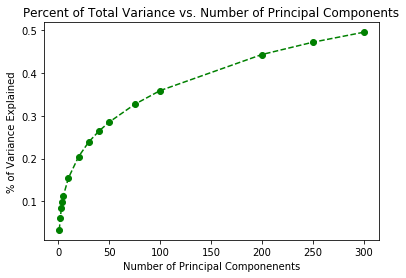

Start time: 2020-08-01 16:11:09.040946
End time: 2020-08-01 17:41:53.008013
Processing time: 1:30:43.967067


In [57]:
#Range of PCA components for experimenting
n_comps = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 75, 100, 200, 250, 300]
var_explained = []

#Try all, to see what gives us best explained variance

start = datetime.datetime.now()
for n_comp in n_comps:
    pca = PCA(n_components=n_comp)

    #Apply the dimensionality reduction
    pca.fit(baby_x)

    #Get the explained variance ratio
    var_explained.append(sum(pca.explained_variance_ratio_))    

end = datetime.datetime.now()
for i in range(len(n_comps)):
    print("n_comp: {0}  , Variance Explained: {1}".format(n_comps[i], var_explained[i]))

plt.plot(n_comps,var_explained, 'go--')
plt.title('Percent of Total Variance vs. Number of Principal Components')
plt.xlabel('Number of Principal Componenents')
plt.ylabel('% of Variance Explained')
plt.show()        


time_diff = end - start

print("Start time: {0}".format(start))
print("End time: {0}".format(end))
print("Processing time: {0}".format(time_diff))

**Here we have used about 5000 rows of data, and tried up to 250 PCA Components and we are only able to capture __ explained variance**